<a href="https://colab.research.google.com/github/AryanMethil/Brain_Tumor_Detection/blob/master/Brain_Tumour_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/My Drive/Brain_Tumor_Classification/src'

/content/drive/My Drive/Brain_Tumor_Classification/src


In [3]:
!pwd

/content/drive/My Drive/Brain_Tumor_Classification/src


In [4]:
import os
import shutil
from cv2 import *
from google.colab.patches import cv2_imshow
from constants import *
import numpy as np

In [5]:
%cd '/content/'


/content


In [7]:
os.makedirs(image_preprocessed_yes,exist_ok=True)
for _,_,files in os.walk(yes):
  for f in files:
    img_path=os.path.join(yes,f)
    norm=imread(img_path)
    norm=cvtColor(norm,COLOR_BGR2GRAY)
    th1=equalizeHist(norm)
    
    th1=dilate(th1,np.ones((4,4),np.uint8),iterations=1)
    th1=erode(th1,np.ones((4,4),np.uint8),iterations=1)
    imwrite(image_preprocessed_yes+f,th1)

os.makedirs(image_preprocessed_no,exist_ok=True)
for _,_,files in os.walk(no):
  for f in files:
    img_path=os.path.join(no,f)
    norm=imread(img_path)
    norm=cvtColor(norm,COLOR_BGR2GRAY)
    th1=equalizeHist(norm)
    
    th1=dilate(th1,np.ones((4,4),np.uint8),iterations=1)
    th1=erode(th1,np.ones((4,4),np.uint8),iterations=1)
    imwrite(image_preprocessed_no+f,th1)

In [8]:
brain_tumour_no= image_preprocessed_no
brain_tumour_yes=image_preprocessed_yes

In [9]:
os.makedirs(image_generator_train_yes,exist_ok=True)
os.makedirs(image_generator_train_no,exist_ok=True)
os.makedirs(image_generator_validation_yes,exist_ok=True)
os.makedirs(image_generator_validation_no,exist_ok=True)

In [10]:
for dir,subdir,files in os.walk(brain_tumour_no):
  for f in files[:int(len(files)*0.7)]:
    shutil.copy(os.path.join(brain_tumour_no,f),image_generator_train_no)
  for f in files[int(len(files)*0.7):]:
    shutil.copy(os.path.join(brain_tumour_no,f),image_generator_validation_no)


In [11]:
for dir,subdir,files in os.walk(brain_tumour_yes):
  for f in files[:int(len(files)*0.7)]:
    shutil.copy(os.path.join(brain_tumour_yes,f),image_generator_train_yes)
  for f in files[int(len(files)*0.7):]:
    shutil.copy(os.path.join(brain_tumour_yes,f),image_generator_validation_yes)

In [12]:
import tensorflow as tf


In [13]:

base_model=tf.keras.applications.InceptionV3(include_top=False,weights='imagenet',input_shape=(150,150,3))
base_model.trainable=False
model=tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model.summary()

87916544/87910968 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2359424   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 24,162,337
Trainable params: 2,359,553
Non-trainable params: 21,802,784
_________________________________________________________________


In [14]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy',tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')])

In [15]:
train_data_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
                                  rotation_range=30,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  shear_range=0.6,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
validation_data_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

In [16]:
train_gen=train_data_generator.flow_from_directory(image_generator_train,
                                                   target_size=(150,150),
                                                   class_mode='binary',
                                                   batch_size=8,
                                                   shuffle=True)
validation_gen=train_data_generator.flow_from_directory(image_generator_validation,
                                                   target_size=(150,150),
                                                   class_mode='binary',
                                                   batch_size=8,
                                                   shuffle=True)

Found 182 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


In [17]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs['accuracy']>0.99):
      self.model.stop_training=True
callbacks=MyCallback()

In [18]:
history=model.fit(train_gen,validation_data=validation_gen,epochs=200,callbacks=callbacks)

Epoch 1/200
23/23 [==============================] - 4s 185ms/step - loss: 1.3092 - accuracy: 0.5495 - precision: 0.6226 - recall: 0.6111 - val_loss: 0.4472 - val_accuracy: 0.7848 - val_precision: 0.8000 - val_recall: 0.8511
Epoch 2/200
23/23 [==============================] - 2s 90ms/step - loss: 0.6556 - accuracy: 0.6923 - precision: 0.7321 - recall: 0.7593 - val_loss: 0.4731 - val_accuracy: 0.7595 - val_precision: 0.7333 - val_recall: 0.9362
Epoch 3/200
23/23 [==============================] - 2s 94ms/step - loss: 0.4338 - accuracy: 0.8077 - precision: 0.8349 - recall: 0.8426 - val_loss: 0.3691 - val_accuracy: 0.8354 - val_precision: 0.8400 - val_recall: 0.8936
Epoch 4/200
23/23 [==============================] - 2s 96ms/step - loss: 0.4427 - accuracy: 0.8077 - precision: 0.8476 - recall: 0.8241 - val_loss: 0.4560 - val_accuracy: 0.7848 - val_precision: 0.8125 - val_recall: 0.8298
Epoch 5/200
23/23 [==============================] - 2s 96ms/step - loss: 0.4226 - accuracy: 0.7912 - p

In [19]:
model.save(models_directory+'HistEq_Morphological_model.h5')

In [20]:
epochs=200

Text(0.5, 1.0, 'Training and validation Recall')

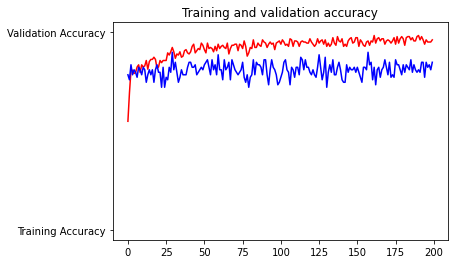

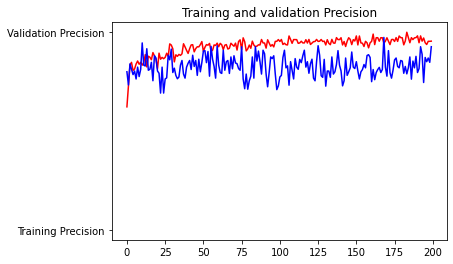

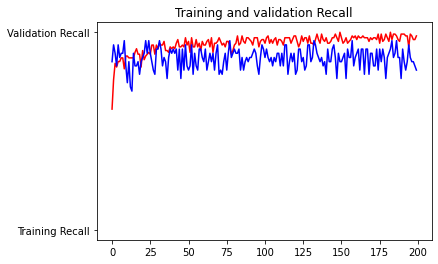

In [21]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
precision=history.history['precision']
val_precision=history.history['val_precision']
recall=history.history['recall']
val_recall=history.history['val_recall']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation Precision per epoch
#------------------------------------------------
plt.plot(epochs, precision, 'r', "Training Precision")
plt.plot(epochs, val_precision, 'b', "Validation Precision")
plt.title('Training and validation Precision')
plt.figure()

plt.plot(epochs, recall, 'r', "Training Recall")
plt.plot(epochs, val_recall, 'b', "Validation Recall")
plt.title('Training and validation Recall')
